In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

from scipy import stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from causalgraphicalmodels import CausalGraphicalModel
import daft

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is based on the [homework of week 8](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week08.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/blob/Experimental/data/)
<br>

Problem 2)<br> 
In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 200, a typical Bengali woman had only 2 or 3. You're going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in data(bangladesh) and come from the 1988 Bangladesh Fertility Survey. Each row is one of the 1934 women. There are 6 variables but focus on 2 of them for this practice problem:
1. district: ID number of administrative district each woman resided in.
2. use.contraception: An indicator (0/1) of whether the woman was using contraception.

In [2]:
df = pd.read_csv('../data/bangladesh.csv', sep=';')

# remove dots from columns names to become easier to address them
df.rename(columns= {'use.contraception': 'use_contraception', 
                    'living.children': 'living_children',
                    'age.centered': 'age_centered'}, inplace=True)
df

,woman,district,use_contraception,living_children,age_centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1
...,...,...,...,...,...,...
1929,1930,61,0,4,14.4400,0
1930,1931,61,0,3,-4.5599,0
1931,1932,61,0,4,14.4400,0
1932,1933,61,0,1,-13.5600,0


In [3]:
df.district.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 55, 56, 57, 58, 59, 60, 61])

By checking the values from district we perceive number `54` is missing. Below, a contiguous integer set is created.

In [4]:
df['dist_id'] = df.district.factorize()[0]
df.head()

,woman,district,use_contraception,living_children,age_centered,urban,dist_id
0,1,1,0,4,18.4400,1,0
1,2,1,0,1,-5.5599,1,0
2,3,1,0,3,1.4400,1,0
3,4,1,0,4,8.4400,1,0
4,5,1,0,1,-13.5590,1,0


## m1: Fixed-effects model

In [5]:
with pm.Model() as m1:
    a_dist = pm.Normal('a_dist', 0, 1.5, shape=len(df.dist_id.unique()))
    p = pm.math.invlogit(a_dist[df.dist_id.values])
    
    contraception = pm.Binomial('contraception', n=1, p=p, observed=df.use_contraception.values)
    
    m1_trace = pm.sample()
    m1_post_pred = pm.sample_posterior_predictive(m1_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dist]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (60), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_dist\n0'}>,
        <AxesSubplot:title={'center':'a_dist\n0'}>],
       [<AxesSubplot:title={'center':'a_dist\n1'}>,
        <AxesSubplot:title={'center':'a_dist\n1'}>],
       [<AxesSubplot:title={'center':'a_dist\n2'}>,
        <AxesSubplot:title={'center':'a_dist\n2'}>],
       [<AxesSubplot:title={'center':'a_dist\n3'}>,
        <AxesSubplot:title={'center':'a_dist\n3'}>],
       [<AxesSubplot:title={'center':'a_dist\n4'}>,
        <AxesSubplot:title={'center':'a_dist\n4'}>],
       [<AxesSubplot:title={'center':'a_dist\n5'}>,
        <AxesSubplot:title={'center':'a_dist\n5'}>],
       [<AxesSubplot:title={'center':'a_dist\n6'}>,
        <AxesSubplot:title={'center':'a_dist\n6'}>],
       [<AxesSubplot:title={'center':'a_dist\n7'}>,
        <AxesSubplot:title={'center':'a_dist\n7'}>],
       [<AxesSubplot:title={'center':'a_dist\n8'}>,
        <AxesSubplot:title={'center':'a_dist\n8'}>],
       [<AxesSubplot:title={'center':'a_dist\n9'}>,
   

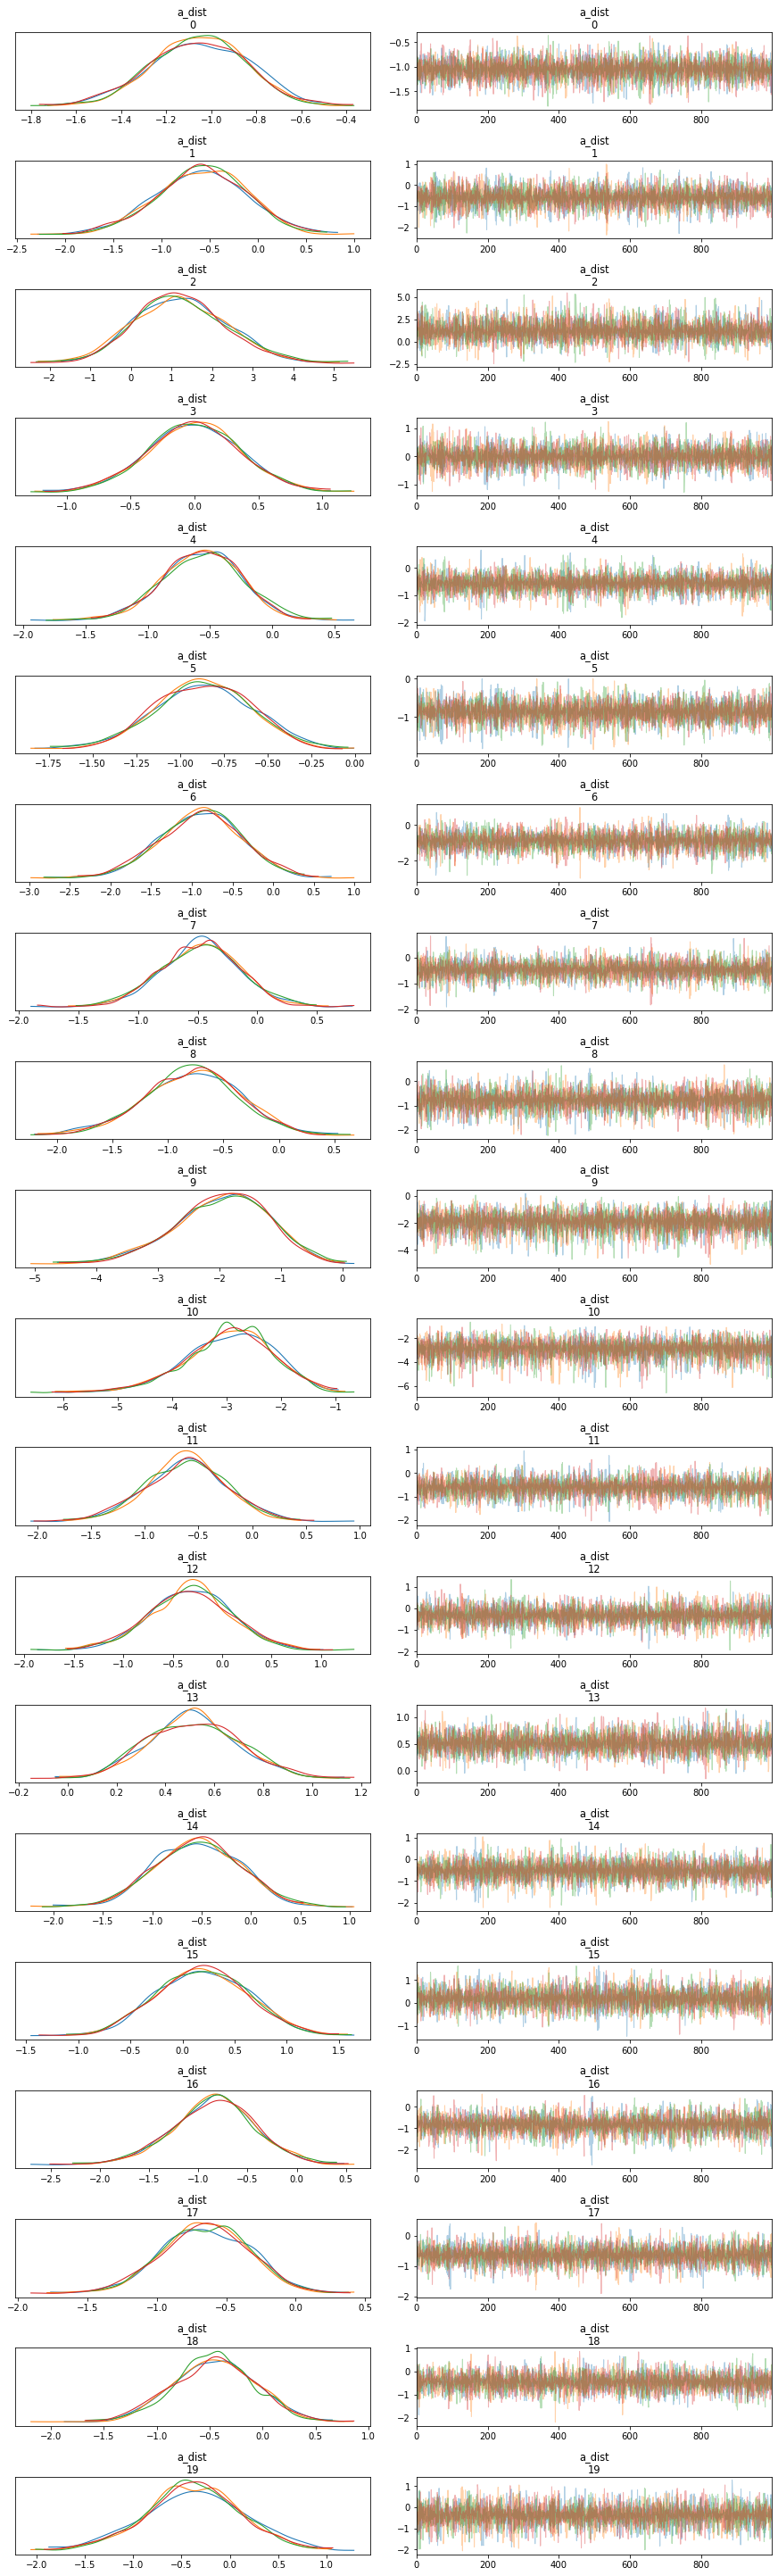

In [6]:
az.plot_trace(m1_trace)

## m2: Multilevel model with varying intercepts

In [7]:
with pm.Model() as m2:
    a_bar = pm.Normal('a_bar', 0, 1)
    sigma = pm.Exponential('sigma', 1)
    
    a_dist = pm.Normal('a_dist', a_bar, sigma, shape=len(df.dist_id.unique()))
    #a_dist = pm.Normal('a_dist', 0, 1.5, shape=len(df.dist_id.unique()))
    p = pm.math.invlogit(a_dist[df.dist_id.values])
    
    contraception = pm.Binomial('contraception', n=1, p=p, observed=df.use_contraception.values)
    
    m2_trace = pm.sample()
    m2_post_pred = pm.sample_posterior_predictive(m2_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_dist, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (62), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_dist\n0'}>,
        <AxesSubplot:title={'center':'a_dist\n0'}>],
       [<AxesSubplot:title={'center':'a_dist\n1'}>,
        <AxesSubplot:title={'center':'a_dist\n1'}>],
       [<AxesSubplot:title={'center':'a_dist\n2'}>,
        <AxesSubplot:title={'center':'a_dist\n2'}>],
       [<AxesSubplot:title={'center':'a_dist\n3'}>,
        <AxesSubplot:title={'center':'a_dist\n3'}>],
       [<AxesSubplot:title={'center':'a_dist\n4'}>,
        <AxesSubplot:title={'center':'a_dist\n4'}>],
       [<AxesSubplot:title={'center':'a_dist\n5'}>,
        <AxesSubplot:title={'center':'a_dist\n5'}>],
       [<AxesSubplot:title={'center':'a_dist\n6'}>,
        <AxesSubplot:title={'center':'a_dist\n6'}>],
       [<AxesSubplot:title={'center':'a_dist\n7'}>,
        <AxesSubplot:title={'center':'a_dist\n7'}>],
       [<AxesSubplot:title={'center':'a_dist\n8'}>,
        <Ax

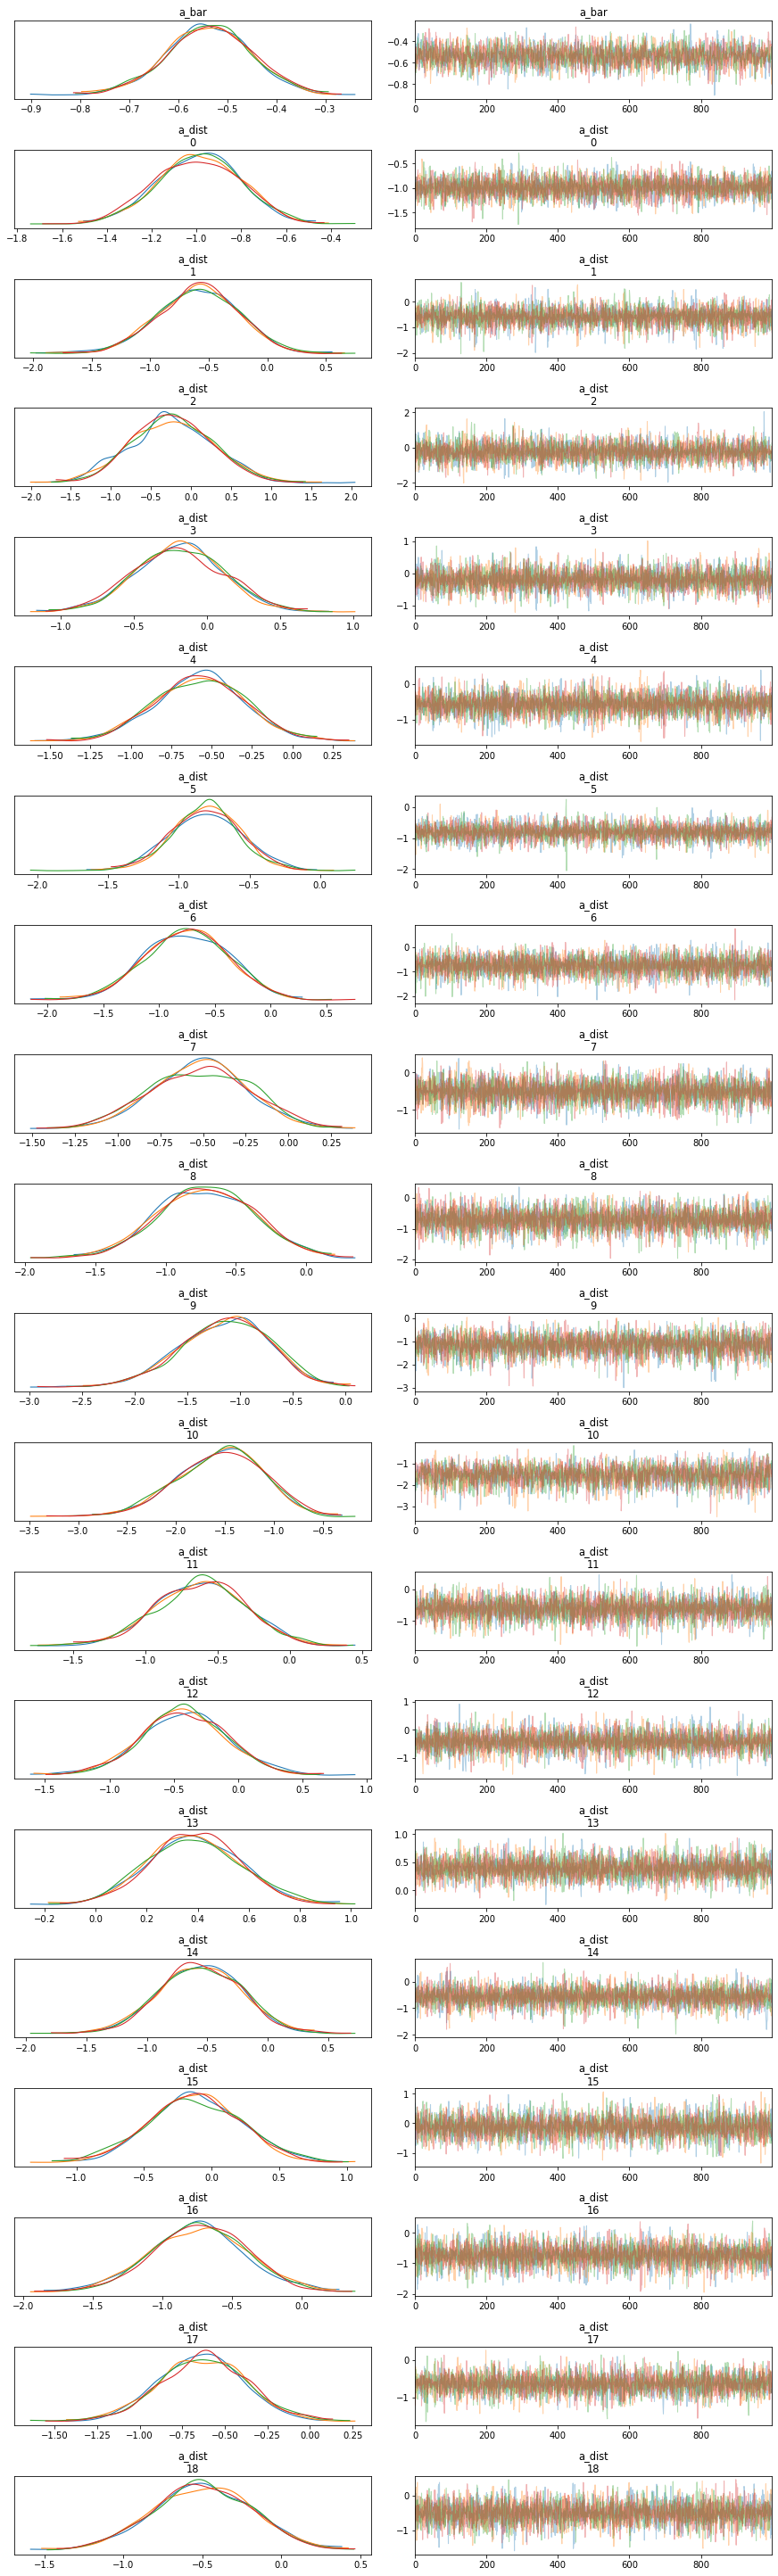

In [8]:
az.plot_trace(m2_trace)

In [9]:
#df['m1_contraception'] = (m1_post_pred['contraception'].mean(0))
#df['m2_contraception'] = (m2_post_pred['contraception'].mean(0))
#df_sum = pd.pivot_table(df.copy(), values=['use_contraception','m1_contraception', 'm2_contraception'],
#                        index=['dist_id'], 
#                        aggfunc={'dist_id':np.size, 'use_contraception':np.sum, 
#                                 'm1_contraception': np.sum, 'm2_contraception': np.sum})
df_sum = pd.pivot_table(df, values=['use_contraception'], index=['dist_id'], 
                        aggfunc={'dist_id':np.size, 'use_contraception':np.sum})

df_sum['m1_a'] = m1_trace['a_dist'].mean(0)
df_sum['m2_a'] = m2_trace['a_dist'].mean(0)

df_sum.rename(columns={'dist_id': 'total_women'}, inplace=True)

[]

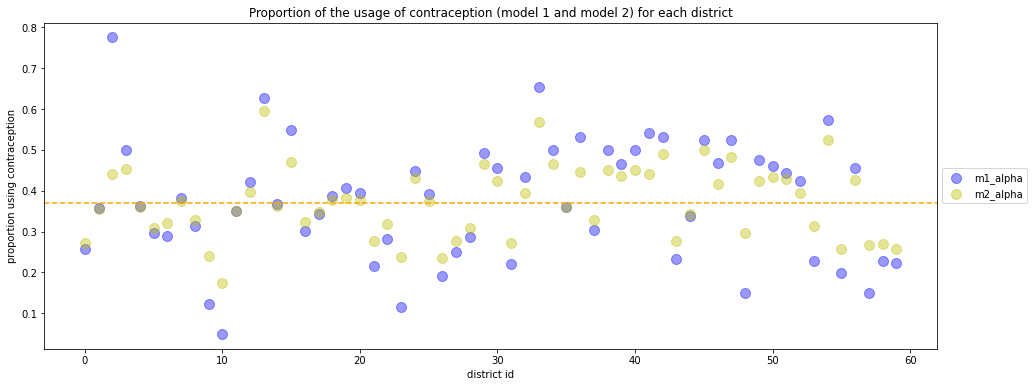

In [10]:
_, ax = plt.subplots(figsize=(16,6))
ax.scatter(df_sum.index, logistic(df_sum.m1_a), c='b', s=100, alpha=0.4, label='m1_alpha')
ax.scatter(df_sum.index, logistic(df_sum.m2_a), c='y', s=100, alpha=0.4, label='m2_alpha')

estimated_median = logistic(m2_trace['a_bar'].mean())
ax.axhline(estimated_median, 0, 1, color='orange', ls='--')

ax.set_title('Proportion of the usage of contraception (model 1 and model 2) for each district')
ax.set_xlabel('district id')
ax.set_ylabel('proportion using contraception')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.plot()

The plot above shows the proportion of usage of contraception by both models for each district. The blue dots are the proportions of model 1 and the yellow dots corresponds to the model proportions to the model 2. <br>
The horizontal dashed line is the estimated median use contraception in the population of districts.
<br>
<br>
The multilevel model (m2) estimates are, in every case, closer to the median line than the empirical model (m1). This is called **shrinkage** and can be seem as if the yellow lines have shrunk towards the median line.
<br>
It can be noticed that for the 3rd district the shrinkage is the biggest, this is because only to women were sampled.
<br>
This can be explained by **pooling**, it means that, for the multilevel model, each district provides information that can be used to improve the estimates for all the other ones.

---
---

In [11]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Wed Apr 07 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

pymc3     : 3.9.3
daft      : 0.1.0
scipy     : 1.5.4
matplotlib: 3.3.2
seaborn   : 0.11.0
pandas    : 1.0.5
arviz     : 0.10.0
numpy     : 1.19.1

Watermark: 2.1.0

